In [84]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import pykitti
import sys
from math import *

%matplotlib inline
np.random.seed(777)

In [2]:
print(sys.path)

['C:\\Users\\kkimu\\Desktop\\Sensor_fusion', 'C:\\Users\\kkimu\\anaconda3\\envs\\mlagent\\python37.zip', 'C:\\Users\\kkimu\\anaconda3\\envs\\mlagent\\DLLs', 'C:\\Users\\kkimu\\anaconda3\\envs\\mlagent\\lib', 'C:\\Users\\kkimu\\anaconda3\\envs\\mlagent', '', 'C:\\Users\\kkimu\\anaconda3\\envs\\mlagent\\lib\\site-packages', 'C:\\Users\\kkimu\\anaconda3\\envs\\mlagent\\lib\\site-packages\\win32', 'C:\\Users\\kkimu\\anaconda3\\envs\\mlagent\\lib\\site-packages\\win32\\lib', 'C:\\Users\\kkimu\\anaconda3\\envs\\mlagent\\lib\\site-packages\\Pythonwin', 'C:\\Users\\kkimu\\anaconda3\\envs\\mlagent\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\kkimu\\.ipython']


In [4]:
# sys.path.append('./src')

from kalman_filters import ExtendedKalmanFilter as EKF
from utils import lla_to_enu, normalize_angles

# Load KITTI GPS/IMU sequence

In [5]:
kitti_root_dir = 'data/kitti'
kitti_date = '2011_09_30'
kitti_drive = '0033'

dataset = pykitti.raw(kitti_root_dir, kitti_date, kitti_drive)

Extract vehicle GPS trajectory, yaw angle, yaw rate, and forward velocity from KITTI OXTS senser packets.

These are treated as ground-truth trajectory in this experiment.

In [6]:
gt_trajectory_lla = []  # [longitude(deg), latitude(deg), altitude(meter)] x N
gt_yaws = []  # [yaw_angle(rad),] x N
gt_yaw_rates= []  # [vehicle_yaw_rate(rad/s),] x N
gt_forward_velocities = []  # [vehicle_forward_velocity(m/s),] x N

for oxts_data in dataset.oxts:
    packet = oxts_data.packet
    gt_trajectory_lla.append([
        packet.lon,
        packet.lat,
        packet.alt
    ])
    gt_yaws.append(packet.yaw)
    gt_yaw_rates.append(packet.wz)
    gt_forward_velocities.append(packet.vf)

gt_trajectory_lla = np.array(gt_trajectory_lla).T
gt_yaws = np.array(gt_yaws)
gt_yaw_rates = np.array(gt_yaw_rates)
gt_forward_velocities = np.array(gt_forward_velocities)

Extract vehicle GPS trajectory, yaw angle, yaw rate, and forward velocity from KITTI OXTS senser packets.

These are treated as ground-truth trajectory in this experiment.

In [7]:
gt_trajectory_lla = []  # [longitude(deg), latitude(deg), altitude(meter)] x N
gt_yaws = []  # [yaw_angle(rad),] x N
gt_yaw_rates= []  # [vehicle_yaw_rate(rad/s),] x N
gt_forward_velocities = []  # [vehicle_forward_velocity(m/s),] x N

for oxts_data in dataset.oxts:
    packet = oxts_data.packet
    gt_trajectory_lla.append([
        packet.lon,
        packet.lat,
        packet.alt
    ])
    gt_yaws.append(packet.yaw)
    gt_yaw_rates.append(packet.wz)
    gt_forward_velocities.append(packet.vf)

gt_trajectory_lla = np.array(gt_trajectory_lla).T
gt_yaws = np.array(gt_yaws)
gt_yaw_rates = np.array(gt_yaw_rates)
gt_forward_velocities = np.array(gt_forward_velocities)

## Plot ground-truth GPS trajectory

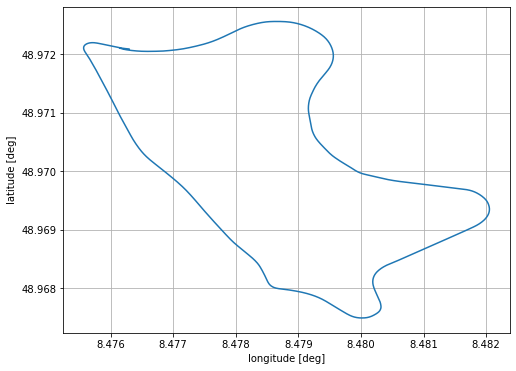

In [8]:
lons, lats, _ = gt_trajectory_lla

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(lons, lats)
ax.set_xlabel('longitude [deg]')
ax.set_ylabel('latitude [deg]')
ax.grid();

**Transform** GPS trajectory from [lon, lat, alt] to local [x, y, z] coord so that Kalman filter can handle it.

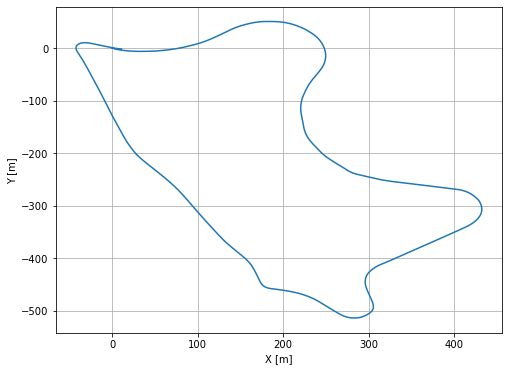

In [9]:
origin = gt_trajectory_lla[:, 0]  # set the initial position to the origin
gt_trajectory_xyz = lla_to_enu(gt_trajectory_lla, origin)

xs, ys, _ = gt_trajectory_xyz
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(xs, ys)
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.grid();

Extract timestamps from KITTI data and convert them to seconds elapsed from the first one.

In [10]:
timestamps = np.array(dataset.timestamps)
elapsed = np.array(timestamps) - timestamps[0]
ts = [t.total_seconds() for t in elapsed]


## Plot ground-truth yaw angles, yaw rates, and forward velocitis

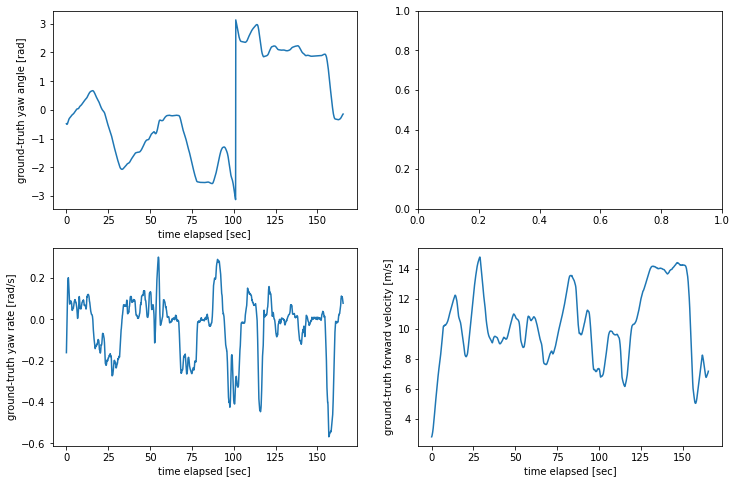

In [11]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

ax[0, 0].plot(ts, gt_yaws)
ax[0, 0].set_xlabel('time elapsed [sec]')
ax[0, 0].set_ylabel('ground-truth yaw angle [rad]')

ax[1, 0].plot(ts, gt_yaw_rates)
ax[1, 0].set_xlabel('time elapsed [sec]')
ax[1, 0].set_ylabel('ground-truth yaw rate [rad/s]')

ax[1, 1].plot(ts, gt_forward_velocities)
ax[1, 1].set_xlabel('time elapsed [sec]')
ax[1, 1].set_ylabel('ground-truth forward velocity [m/s]');


## Add gaussian noise to KITTI GPU/IMU data

Add gaussian noise to the ground-truth GPS/IMU data.

Those are used as noisy observations given to Kalman filter later.

### Add noise to GPS data

In [13]:
N = len(ts)  # number of data point

In [14]:
xy_obs_noise_std = 1.0  # standard deviation of observation noise of x and y in meter

xy_obs_noise = np.random.normal(0.0, xy_obs_noise_std, (2, N))  # gen gaussian noise
obs_trajectory_xyz = gt_trajectory_xyz.copy()
obs_trajectory_xyz[:2, :] += xy_obs_noise  # add the noise to ground-truth positions

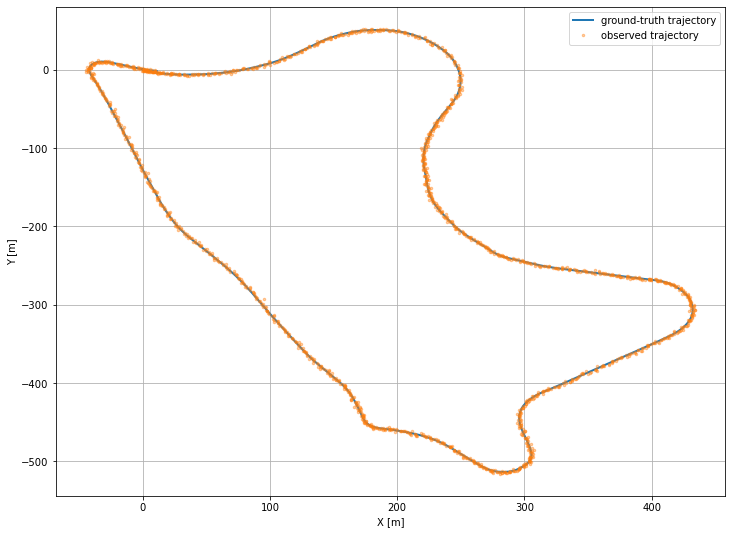

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(12, 9))

xs, ys, _ = gt_trajectory_xyz
ax.plot(xs, ys, lw=2, label='ground-truth trajectory')

xs, ys, _ = obs_trajectory_xyz
ax.plot(xs, ys, lw=0, marker='.', markersize=5, alpha=0.4, label='observed trajectory')

ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.legend()
ax.grid();

### Add noise to yaw rates

In [16]:
yaw_rate_noise_std = 0.02 # standard deviation of yaw rate in rad/s

yaw_rate_noise = np.random.normal(0.0, yaw_rate_noise_std, (N,))  # gen gaussian noise
obs_yaw_rates = gt_yaw_rates.copy()
obs_yaw_rates += yaw_rate_noise  # add the noise to ground-truth positions

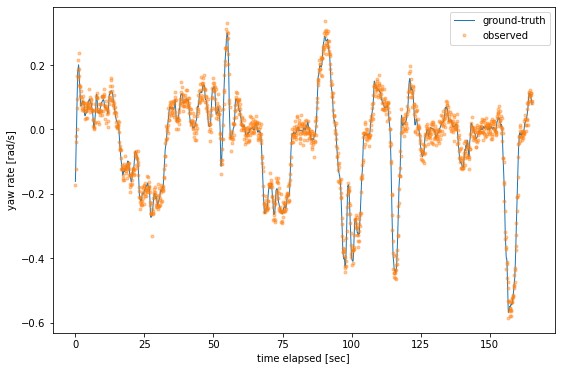

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6))

ax.plot(ts, gt_yaw_rates, lw=1, label='ground-truth')
ax.plot(ts, obs_yaw_rates, lw=0, marker='.', alpha=0.4, label='observed')

ax.set_xlabel('time elapsed [sec]')
ax.set_ylabel('yaw rate [rad/s]')
ax.legend();

### Add noise to forward velocities

In [18]:
forward_velocity_noise_std = 0.3 # standard deviation of forward velocity in m/s

forward_velocity_noise = np.random.normal(0.0, forward_velocity_noise_std, (N,))  # gen gaussian noise
obs_forward_velocities = gt_forward_velocities.copy()
obs_forward_velocities += forward_velocity_noise  # add the noise to ground-truth positions

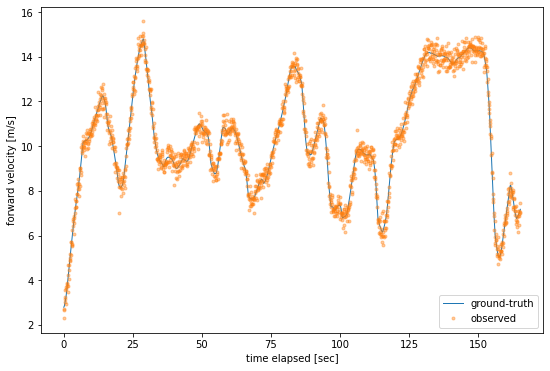

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6))

ax.plot(ts, gt_forward_velocities, lw=1, label='ground-truth')
ax.plot(ts, obs_forward_velocities, lw=0, marker='.', alpha=0.4, label='observed')

ax.set_xlabel('time elapsed [sec]')
ax.set_ylabel('forward velocity [m/s]')
ax.legend();

# Apply Kalman filter

In [44]:
# initial state x_0

initial_yaw_std = np.pi
initial_yaw = gt_yaws[0] + np.random.normal(0, initial_yaw_std)

x = np.array([
    obs_trajectory_xyz[0, 0],
    obs_trajectory_xyz[1, 0],
    initial_yaw
])

In [45]:
# covariance for initial state estimation error (Sigma_0)

P = np.array([
    [xy_obs_noise_std ** 2., 0., 0.],
    [0., xy_obs_noise_std ** 2., 0.],
    [0., 0., initial_yaw_std ** 2.]
])

In [46]:
Q = np.array([
    [xy_obs_noise_std ** 2., 0.],
    [0., xy_obs_noise_std ** 2.]
])

In [47]:
R = np.array([
    [forward_velocity_noise_std ** 2., 0., 0.],
    [0., forward_velocity_noise_std ** 2., 0.],
    [0., 0., yaw_rate_noise_std ** 2.]
])

In [56]:
# initialize Kalman filter
kf = EKF(x, P)

# array to store estimated 2d pose [x, y, theta]
mu_x = [x[0],]
mu_y = [x[1],]
mu_theta = [x[2],]

# array to store estimated error variance of 2d pose
var_x = [P[0, 0],]
var_y = [P[1, 1],]
var_theta = [P[2, 2],]

t_last = 0.
for t_idx in range(1, len(ts)):
    t = ts[t_idx]
    dt = t - t_last
    
    # get control input `u = [v, omega] + noise`
    u = np.array([
        obs_forward_velocities[t_idx],
        obs_yaw_rates[t_idx]
    ])
    
    # because velocity and yaw rate are multiplied with `dt` in state transition function,
    # its noise covariance must be multiplied with `dt**2.`
    R_ = R * (dt ** 2.)
    
    # propagate!
    kf.propagate(u, dt, R)
    
    # get measurement `z = [x, y] + noise`
    z = np.array([
        obs_trajectory_xyz[0, t_idx],
        obs_trajectory_xyz[1, t_idx]
    ])
    
    # update!
    kf.update(z, Q)
    
    # save estimated state to analyze later
    mu_x.append(kf.x[0])
    mu_y.append(kf.x[1])
    mu_theta.append(normalize_angles(kf.x[2]))
    
    # save estimated variance to analyze later
    var_x.append(kf.P[0, 0])
    var_y.append(kf.P[1, 1])
    var_theta.append(kf.P[2, 2])
    
    t_last = t
    

mu_x = np.array(mu_x)
mu_y = np.array(mu_y)
mu_theta = np.array(mu_theta)

var_x = np.array(var_x)
var_y = np.array(var_y)
var_theta = np.array(var_theta)

In [57]:
### reference code ###  ExtendedKalmanFilter:

# references: 
# [1] https://docs.ufpr.br/~danielsantos/ProbabilisticRobotics.pdf

import numpy as np


class ExtendedKalmanFilter:
    """Extended Kalman Filter
    for vehicle whose motion is modeled as eq. (5.9) in [1]
    and with observation of its 2d location (x, y)
    """
    def __init__(self, x, P):
        """ 
        Args:
            x (numpy.array): state to estimate: [x_, y_, theta]^T
            P (numpy.array): estimation error covariance
        """
        self.x = x  #  [3,]
        self.P = P  #  [3, 3]

    def update(self, z, Q):
        """update x and P based on observation of (x_, y_)
        Args:
            z (numpy.array): obsrervation for [x_, y_]^T
            Q (numpy.array): observation noise covariance
        """
        # compute Kalman gain
        H = np.array([
            [1., 0., 0.],
            [0., 1., 0.]
        ])  # Jacobian of observation function

        K = self.P @ H.T @ np.linalg.inv(H @ self.P @ H.T + Q)

        # update state x
        x, y, theta = self.x
        z_ = np.array([x, y])  # expected observation from the estimated state
        self.x = self.x + K @ (z - z_)

        # update covariance P
        self.P = self.P - K @ H @ self.P

    def propagate(self, u, dt, R):
        """propagate x and P based on state transition model defined as eq. (5.9) in [1]
        Args:
            u (numpy.array): control input: [v, omega]^T
            dt (float): time interval in second
            R (numpy.array): state transition noise covariance
        """
        # propagate state x
        x, y, theta = self.x
        v, omega = u
        r = v / omega  # turning radius

        dtheta = omega * dt
        dx = - r * np.sin(theta) + r * np.sin(theta + dtheta)
        dy = + r * np.cos(theta) - r * np.cos(theta + dtheta)

        self.x += np.array([dx, dy, dtheta])

        # propagate covariance P
        G = np.array([
            [1., 0., - r * np.cos(theta) + r * np.cos(theta + dtheta)],
            [0., 1., - r * np.sin(theta) + r * np.sin(theta + dtheta)],
            [0., 0., 1.]
        ])  # Jacobian of state transition function

        self.P = G @ self.P @ G.T + R

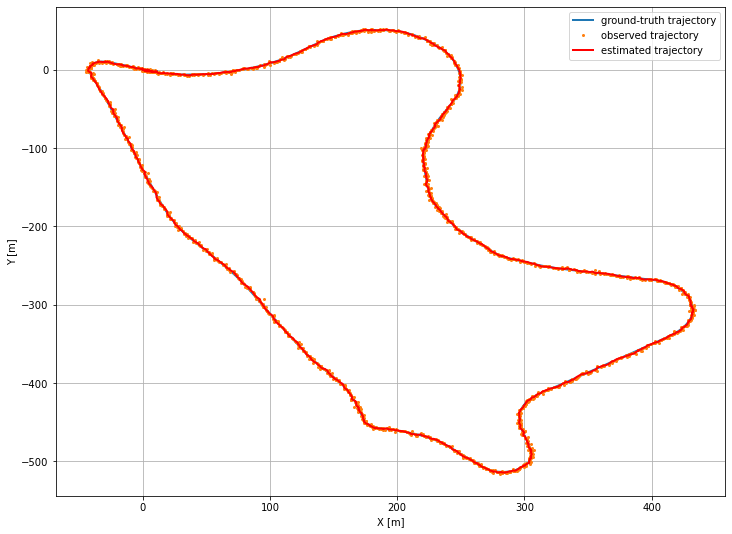

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(12, 9))

xs, ys, _ = gt_trajectory_xyz
ax.plot(xs, ys, lw=2, label='ground-truth trajectory')

xs, ys, _ = obs_trajectory_xyz
ax.plot(xs, ys, lw=0, marker='.', markersize=4, alpha=1., label='observed trajectory')

ax.plot(mu_x, mu_y, lw=2, label='estimated trajectory', color='r')

ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.legend()
ax.grid()

# Apply Particle Filter

In [85]:
import random
import statistics
import time
from IPython.display import HTML
from celluloid import Camera

In [160]:
# world size 
x_min = min(obs_trajectory_xyz[0, :])
x_size = max(obs_trajectory_xyz[0, :]) - x_min

y_min = min(obs_trajectory_xyz[1, :])
y_size = max(obs_trajectory_xyz[1, :]) - y_min 

print('x_min is: ', x_min)
print('x_max is: ', max(obs_trajectory_xyz[0, :]))
print('y_min is: ', y_min)
print('y_max is: ', max(obs_trajectory_xyz[1, :]))


x_min is:  -44.68392056909127
x_max is:  433.99241758108974
y_min is:  -515.608085215924
y_max is:  52.22662645205983


In [22]:
class robot:
  def __init__(self):
      self.x = x_min/2 + random.random() * x_size / 2
      self.y = y_min/2 + random.random() * y_size / 2
      self.orientation = random.random() * 2.0 * pi
      self.forward_noise = 0.0;
      self.turn_noise    = 0.0;
      self.sense_noise   = 0.0;
  
  def set(self, new_x, new_y, new_orientation):
      self.x = float(new_x)
      self.y = float(new_y)
      self.orientation = float(new_orientation)
  
  
  def set_noise(self, new_f_noise, new_t_noise, new_s_noise):
      # makes it possible to change the noise parameters
      # this is often useful in particle filters
      self.forward_noise = float(new_f_noise);
      self.turn_noise    = float(new_t_noise);
      self.sense_noise   = float(new_s_noise);
  
  def sense(self,obs_x, obs_y): # euclidean distance (gps, particle)
      dist = sqrt((self.x - obs_x) ** 2 + (self.y - obs_y) ** 2)
      dist += random.gauss(0.0, self.sense_noise)
      z = dist
      return z
  
  
  def move(self, turn, forward):
    # if forward < 0:
    #   raise ValueError('Robot cant move backwards')         
    
    # turn, and add randomness to the turning command
    orientation = self.orientation + float(turn) + random.gauss(0.0, self.turn_noise)
    orientation %= 2 * pi
    
    # move, and add randomness to the motion command
    dist = float(forward) + random.gauss(0.0, self.forward_noise)
    x = self.x + (cos(orientation) * dist)
    y = self.y + (sin(orientation) * dist)
    
    # set particle
    res = robot()
    res.set(x, y, orientation)
    res.set_noise(self.forward_noise, self.turn_noise, self.sense_noise)
    return res
  
  def Gaussian(self, dist, sigma): # mu : particle, x : GPS sensor measurement 
      
      # calculates the probability of x for 1-dim Gaussian with mean mu and var. sigma
      return exp(- ((dist) ** 2) / (sigma ** 2) / 2.0) / sqrt(2.0 * pi * (sigma ** 2))
  
  
  def measurement_prob(self, gps_x, gps_y): 
      # calculates how likely a measurement should be
      
      measurement = self.sense(gps_x, gps_y)
      prob = 1.0;
      
      error = sqrt((self.x - gps_x) ** 2 + (self.y - gps_y) ** 2)
      prob *= self.Gaussian(error, self.sense_noise)
      return prob
    
  def __repr__(self):
      return '[x=%.6s y=%.6s orient=%.6s]' % (str(self.x), str(self.y), str(self.orientation))


def get_positions(p):
  x = []
  y = []
  orientation = []
  for i in range(len(p)):
    x.append(p[i].x)
    y.append(p[i].y)
    orientation.append(p[i].orientation)
  return x, y, orientation

def eval(gps_x, gps_y, p):
    sum = 0.0;
    for i in range(len(p)): # calculate mean error
        dx = p[i].x - gps_x  # dx = (p[i].x - gps_x + (x_size/2.0)) % x_size - (x_size/2.0)
        dy = p[i].y - gps_y  #  dy = (p[i].y - gps_y + (y_size/2.0)) % y_size - (y_size/2.0)
        err = sqrt(dx * dx + dy * dy)
        sum += err
    return sum / float(len(p))

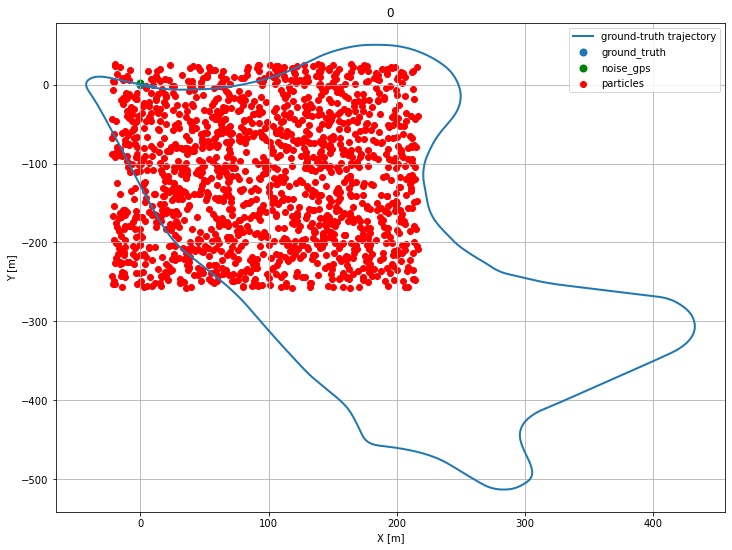

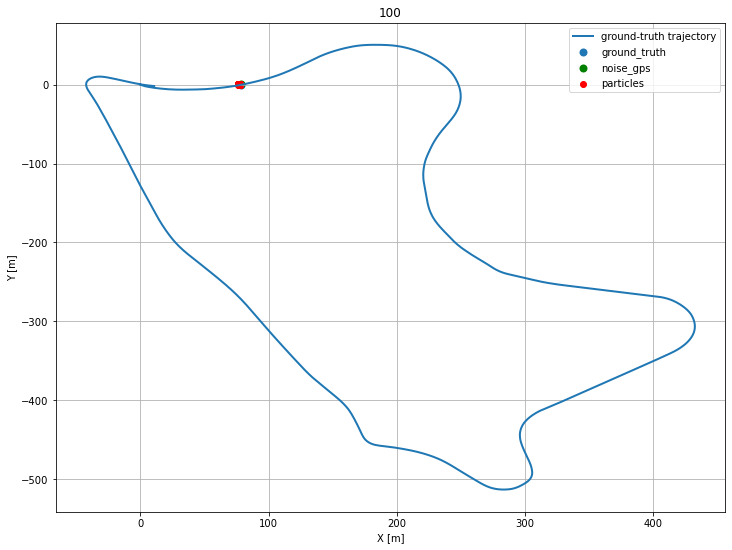

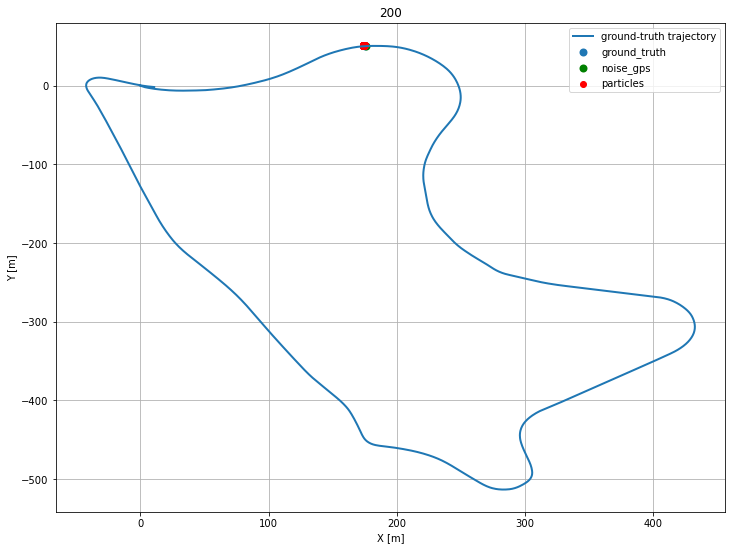

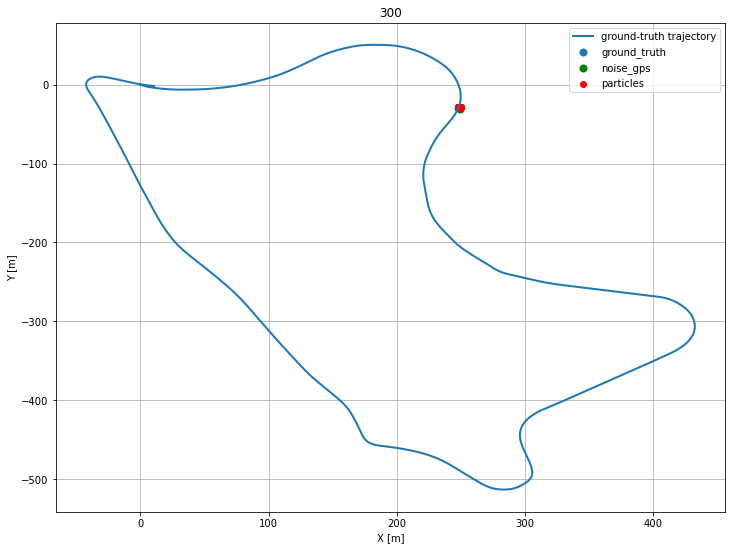

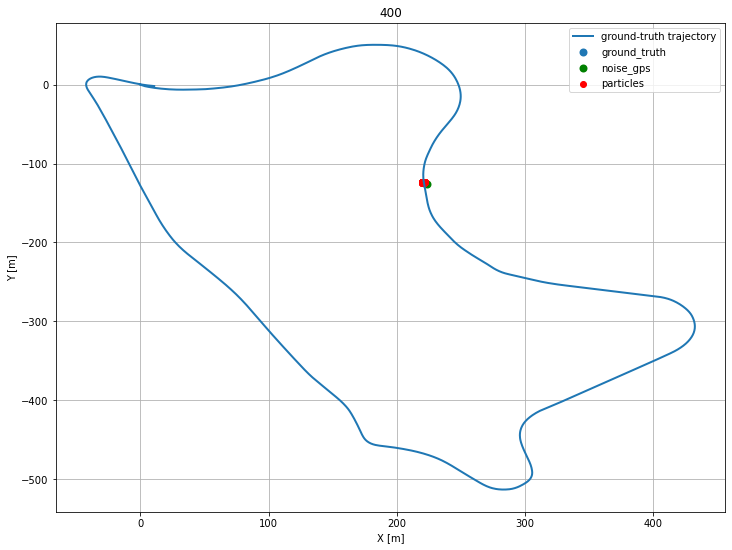

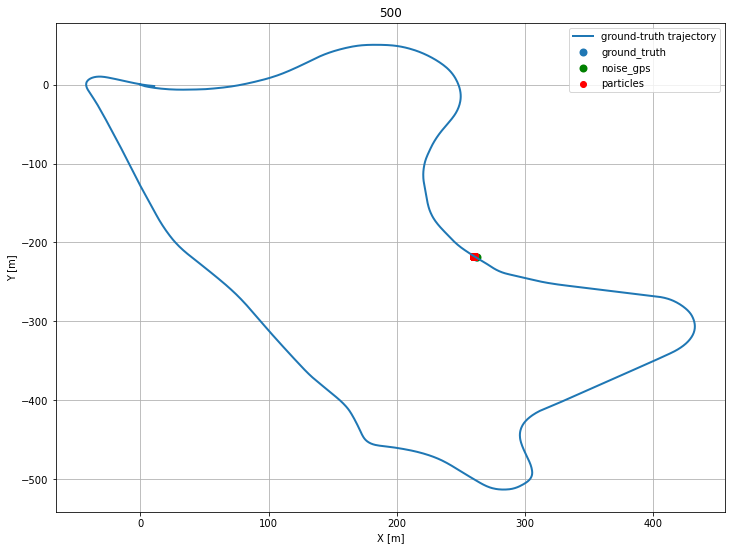

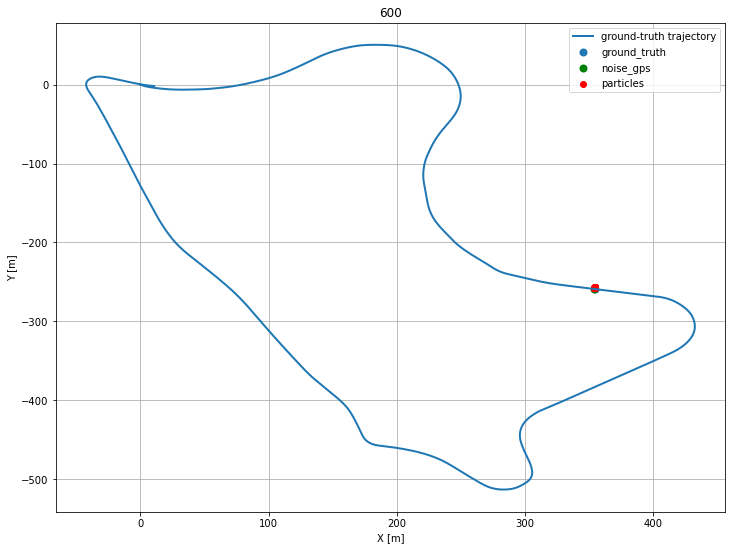

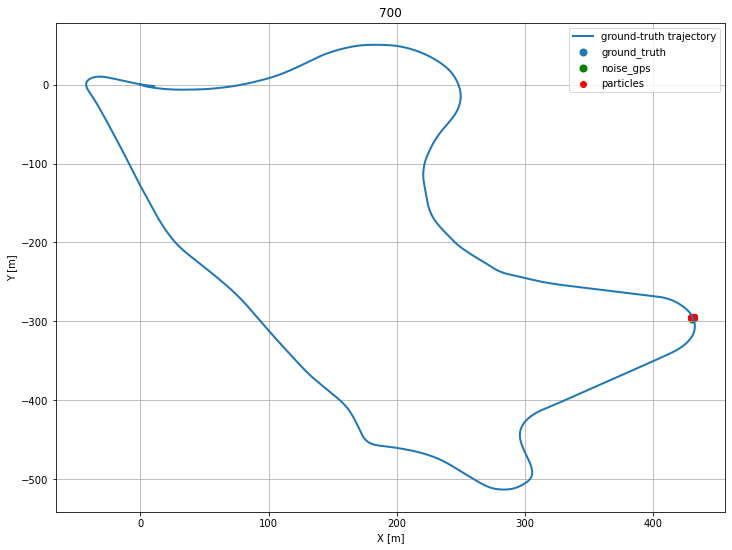

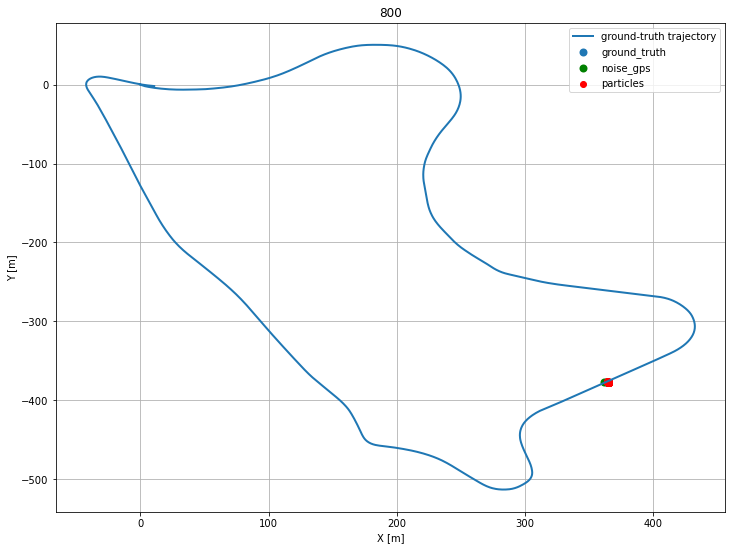

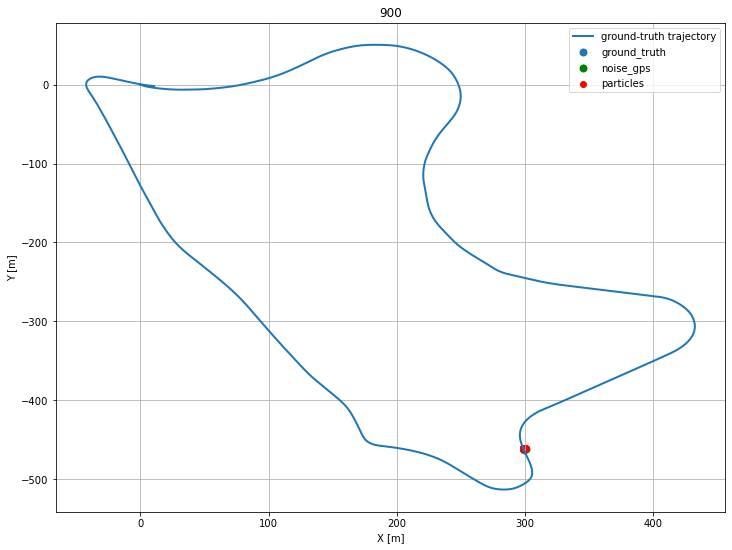

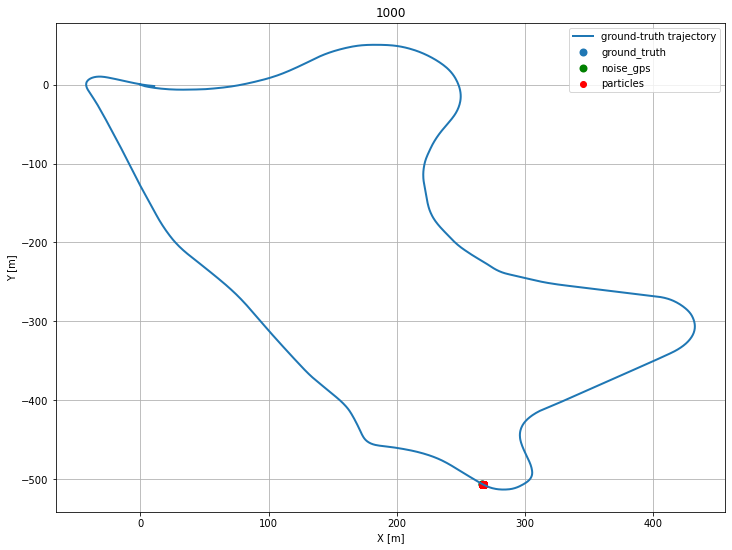

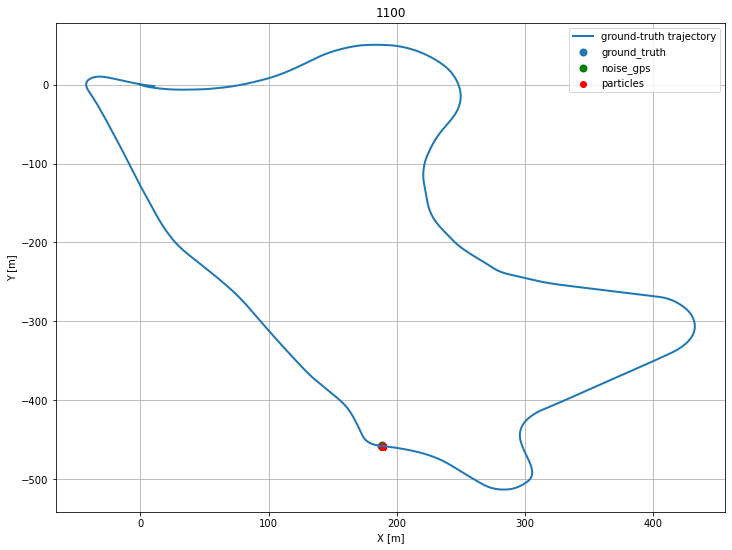

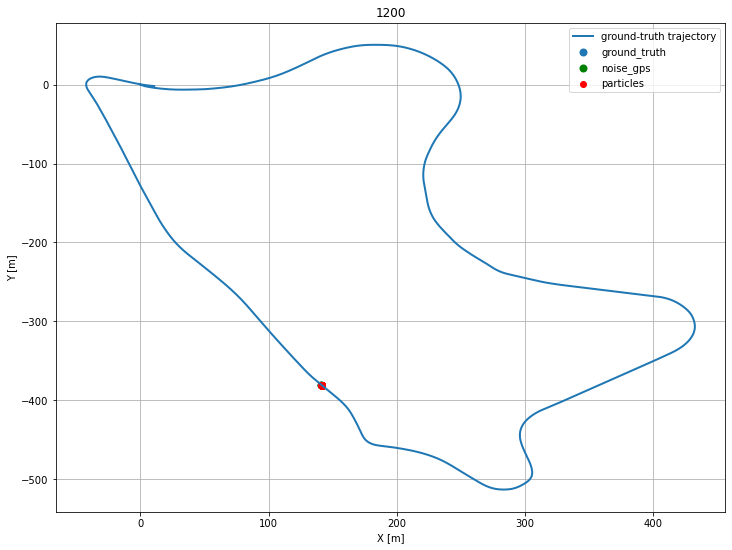

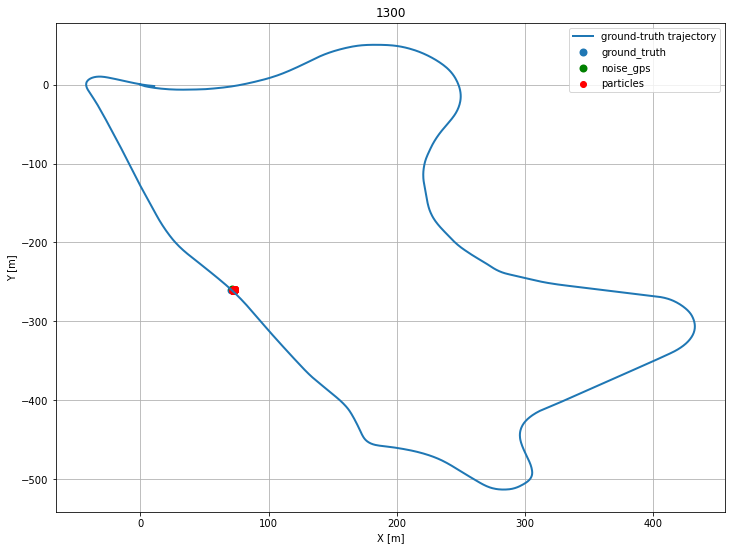

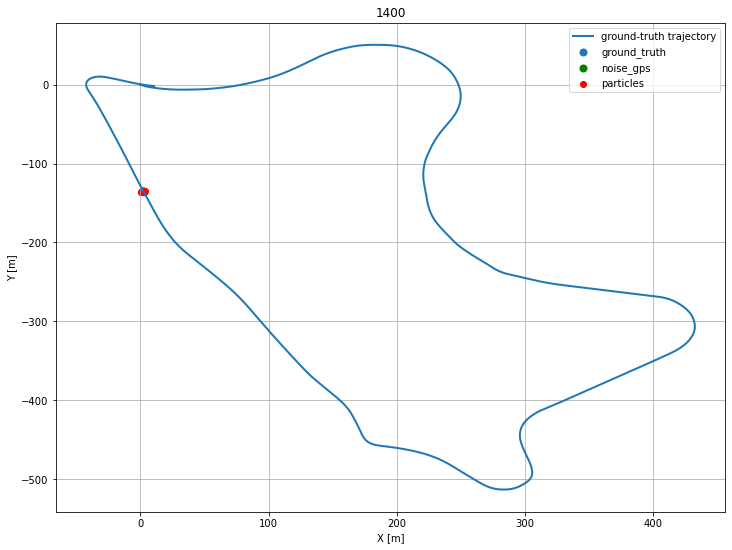

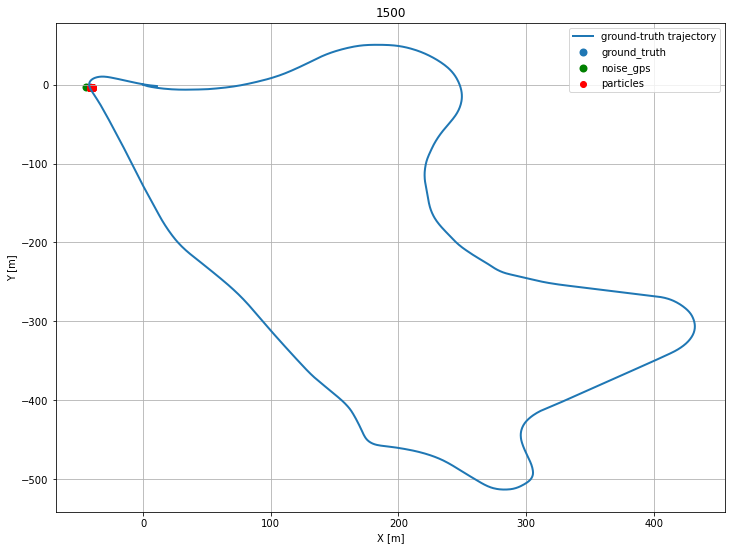

In [174]:
# Particle filter parameter
N = 1500 # Number of particle

# make particles
p = [] 
for i in range(N):
    x = robot()
    x.set_noise(0.1, 0.1, 0.5) # set noise (velocity_noise, turn_noise, gps_noise)
    p.append(x)
m_x = []
m_y = []
m_theta = []
error = []

t_last = 0
xs, ys, theta = gt_trajectory_xyz




# motions, measurements
for t_idx in range(len(ts)):
    
  obs_x = obs_trajectory_xyz[0, t_idx]
  obs_y = obs_trajectory_xyz[1, t_idx]
  # plot
  if (t_idx % 100 == 0): # at every 200 frame
    fig, ax = plt.subplots(1, 1, figsize=(12, 9))
    ax.plot(xs, ys, lw=2, label='ground-truth trajectory')
    ax.scatter(xs[t_idx], ys[t_idx], lw=2, label='ground_truth')
    ax.scatter(obs_x, obs_y, lw=2, label='noise_gps', color='g')
    x_set, y_set, orientation_set = get_positions(p)
    ax.scatter(x_set, y_set, lw=1, label='particles', color='r')
    ax.set_xlabel('X [m]')
    ax.set_ylabel('Y [m]')
    ax.set_title(t_idx)
    ax.legend()  
    ax.grid()
  m_x.append(statistics.mean(x_set))
  m_y.append(statistics.mean(y_set))
  m_theta.append(statistics.mean(orientation_set))

  velocity = obs_forward_velocities[t_idx]
  yaw_rate = obs_yaw_rates[t_idx]

  t_x = obs_trajectory_xyz[0, t_idx]
  t_y = obs_trajectory_xyz[1, t_idx]
  t = ts[t_idx]
  dt = t - t_last  

  # move particle 
  p2 = []
  for i in range(N):
      p2.append(p[i].move(yaw_rate*dt, velocity*dt))
  p = p2
  
  # measurement update
  w = []
  for i in range(N):
      w.append(p[i].measurement_prob(t_x, t_y))
  
#   if (t_idx == 1):
#     fig, bx = plt.subplots(1, 1, figsize=(158, 5))
#     bx.plot(w)
    
  # resampling
  p3 = []
  index = int(random.random() * N)
  beta = 0.0
  mw = max(w)
  for i in range(N):
      beta += random.random() * 2.0 * mw
      while beta > w[index]:
          beta -= w[index]
          index = (index + 1) % N
      p3.append(p[index])
  p = p3
  t_last = t

  error.append(eval(t_x, t_y, p))
  

# Analyse the estimation error

## 1. Estimation error of X

**Kalman Filter**

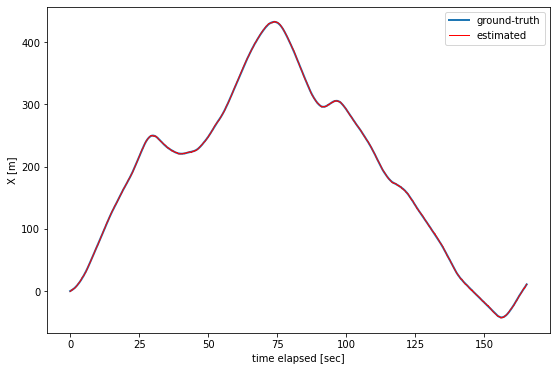

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6))

ax.plot(ts, gt_trajectory_xyz[0], lw=2, label='ground-truth')
#ax.plot(ts, obs_trajectory_xyz[0], lw=0, marker='.', markersize=3, alpha=0.4, label='observed')
ax.plot(ts, mu_x, lw=1, label='estimated', color='r')

ax.set_xlabel('time elapsed [sec]')
ax.set_ylabel('X [m]')
ax.legend();

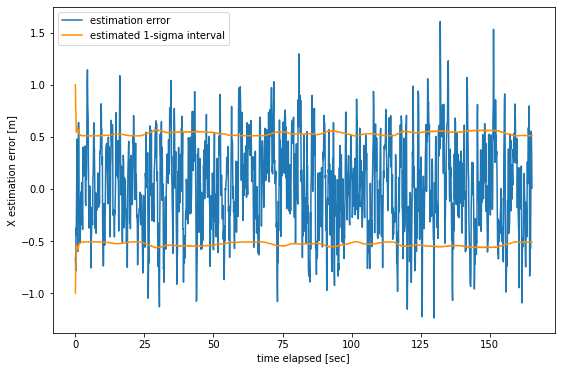

In [61]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6))

ax.plot(ts, mu_x - gt_trajectory_xyz[0], lw=1.5, label='estimation error')
ax.plot(ts, np.sqrt(var_x), lw=1.5, label='estimated 1-sigma interval', color='darkorange')
ax.plot(ts, -np.sqrt(var_x), lw=1.5, label='', color='darkorange')

ax.set_xlabel('time elapsed [sec]')
ax.set_ylabel('X estimation error [m]')
ax.legend();

**Particle Filter**

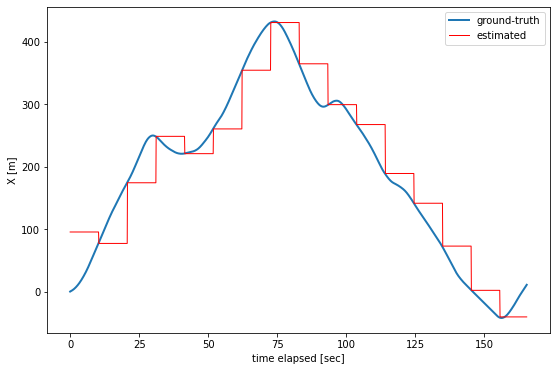

In [175]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6))

ax.plot(ts, gt_trajectory_xyz[0], lw=2, label='ground-truth')
#ax.plot(ts, obs_trajectory_xyz[0], lw=0, marker='.', markersize=3, alpha=0.4, label='observed')
ax.plot(ts, m_x, lw=1, label='estimated', color='r')

ax.set_xlabel('time elapsed [sec]')
ax.set_ylabel('X [m]')
ax.legend();

## 2. Estimation error of Y

**Kalman Filter**

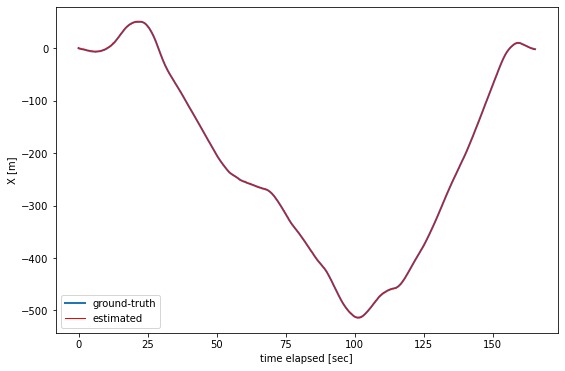

In [70]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6))

ax.plot(ts, gt_trajectory_xyz[1], lw=2, label='ground-truth')
#ax.plot(ts, obs_trajectory_xyz[0], lw=0, marker='.', markersize=3, alpha=0.4, label='observed')
ax.plot(ts, mu_y, lw=1, label='estimated', color='r')

ax.set_xlabel('time elapsed [sec]')
ax.set_ylabel('X [m]')
ax.legend();

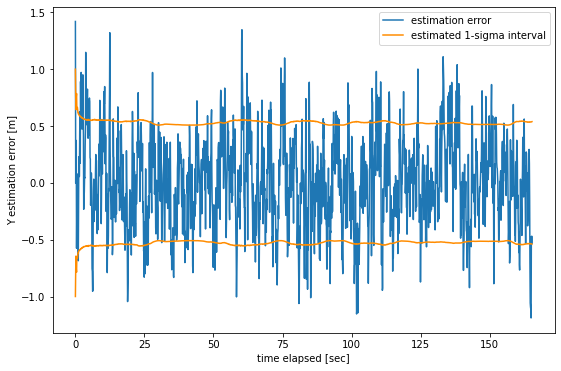

In [71]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6))

ax.plot(ts, mu_y - gt_trajectory_xyz[1], lw=1.5, label='estimation error')
ax.plot(ts, np.sqrt(var_y), lw=1.5, label='estimated 1-sigma interval', color='darkorange')
ax.plot(ts, -np.sqrt(var_y), lw=1.5, label='', color='darkorange')

ax.set_xlabel('time elapsed [sec]')
ax.set_ylabel('Y estimation error [m]')
ax.legend();

**Particle Filter**

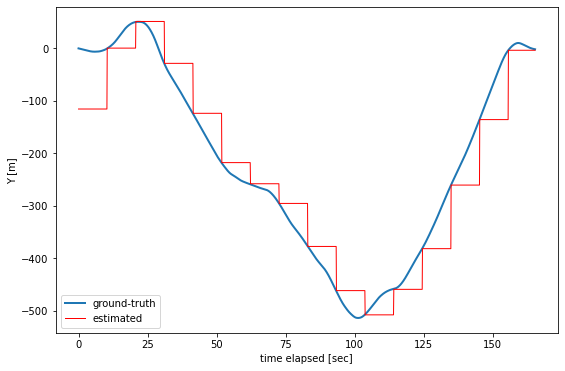

In [176]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6))

ax.plot(ts, gt_trajectory_xyz[1], lw=2, label='ground-truth')
ax.plot(ts, m_y, lw=1, label='estimated', color='r')

ax.set_xlabel('time elapsed [sec]')
ax.set_ylabel('Y [m]')
ax.legend();

## 3. Estimation error of theta

**Kalman Filter**

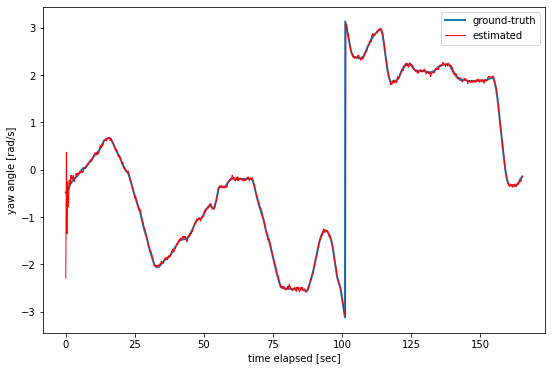

In [75]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6))

ax.plot(ts, gt_yaws, lw=2, label='ground-truth')
ax.plot(ts, mu_theta, lw=1, label='estimated', color='r')

ax.set_xlabel('time elapsed [sec]')
ax.set_ylabel('yaw angle [rad/s]')
ax.legend();

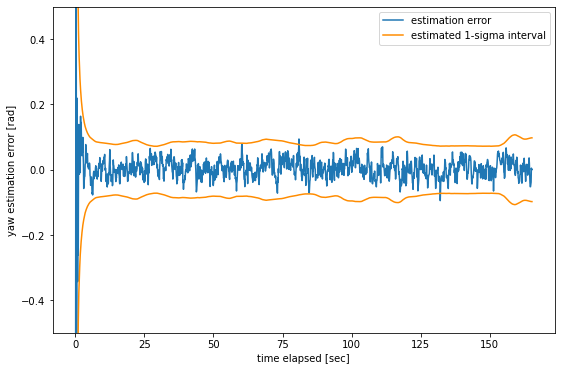

In [151]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6))

ax.plot(ts, normalize_angles(mu_theta - gt_yaws), lw=1.5, label='estimation error')
ax.plot(ts, np.sqrt(var_theta), lw=1.5, label='estimated 1-sigma interval', color='darkorange')
ax.plot(ts, -np.sqrt(var_theta), lw=1.5, label='', color='darkorange')

ax.set_ylim(-0.5, 0.5)

ax.set_xlabel('time elapsed [sec]')
ax.set_ylabel('yaw estimation error [rad]')
ax.legend();

**Particle Filter**

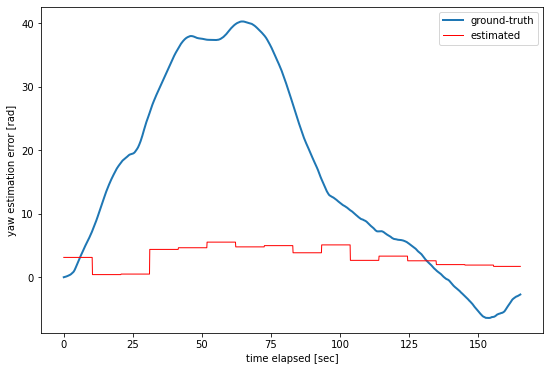

In [178]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6))

ax.plot(ts, gt_trajectory_xyz[2], lw=2, label='ground-truth')
ax.plot(ts, m_theta, lw=1, label='estimated', color='r')

ax.set_xlabel('time elapsed [sec]')
ax.set_ylabel('yaw estimation error [rad]')
ax.legend();

## 4. Mean distance error

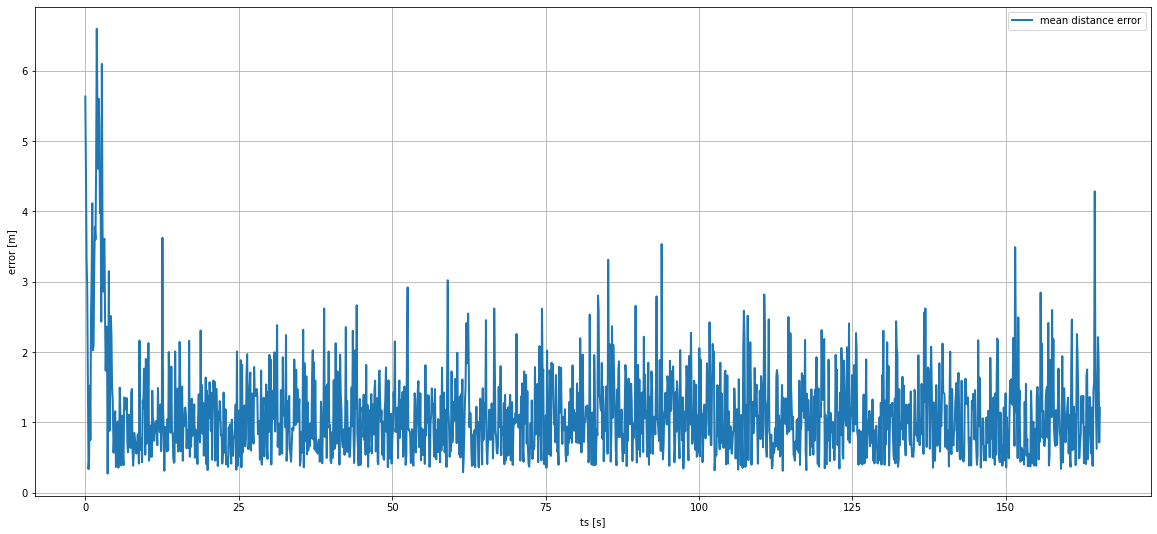

In [179]:
fig, ax = plt.subplots(1, 1, figsize=(20, 9))
ax.plot(ts, error, lw=2, label='mean distance error')
ax.set_xlabel('ts [s]')
ax.set_ylabel('error [m]')
ax.legend()  
ax.grid()